In [1]:
path="/Users/xinyanliu/Downloads/Movie Final Data.csv"

In [11]:
df=df = pd.read_csv(path)

In [12]:
pip install pymc

Note: you may need to restart the kernel to use updated packages.


In [13]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd

### Feature Engineering

In [14]:
log_transform_cols = ['Production Budget (USD)', 'Domestic Gross (USD)', 'Worldwide Gross (USD)', 
                      'Opening Weekend (USD)', 'Max Theaters', 'Weeks Run']

for col in log_transform_cols:
    log_col_name = f"{col}_log"
    if log_col_name not in df.columns:  # Avoid duplicate transformations
        df[log_col_name] = np.log1p(df[col])  

In [15]:
# Step 2: Encoding categorical variables
# Using Label Encoding for hierarchical Bayesian modeling (alternative: one-hot for non-hierarchical models)
categorical_cols = ['Genre', 'MPAA Rating', 'Source', 'Creative Type', 'Production Countries']

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store encoders for later use

In [16]:
# Step 3: Standardizing numerical variables (except target)
numerical_cols = ['Production Budget (USD)_log', 'Opening Weekend (USD)_log', 'Max Theaters_log', 'Weeks Run_log']
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

### Hierarchy Regression Model

In [17]:
import pymc as pm
import numpy as np
import arviz as az

In [18]:
# Extract relevant data for modeling
y = df["Worldwide Gross (USD)_log"].values
X = df[["Production Budget (USD)_log", "Opening Weekend (USD)_log", "Max Theaters_log", "Weeks Run_log"]].values

# Group indices for hierarchical structure
genre_idx = df["Genre"].values
mpaa_idx = df["MPAA Rating"].values
country_idx = df["Production Countries"].values

# Number of unique categories for hierarchical priors
num_genres = df["Genre"].nunique()
num_mpaa = df["MPAA Rating"].nunique()
num_countries = df["Production Countries"].nunique()


In [19]:
# Apply log transformation if missing
log_transform_cols = ["Opening Weekend (USD)", "Max Theaters", "Weeks Run"]

for col in log_transform_cols:
    log_col_name = f"{col}_log"
    if log_col_name not in df.columns:  # Avoid duplicate transformations
        df[log_col_name] = np.log1p(df[col])

# Verify the transformed columns are now present
df[[f"{col}_log" for col in log_transform_cols]].head()


,Opening Weekend (USD)_log,Max Theaters_log,Weeks Run_log
0,NaN,-0.30634,-2.086858
1,NaN,-0.30634,-2.086858
2,NaN,-0.30634,-2.086858
3,NaN,-0.30634,-2.086858
4,NaN,-0.30634,-2.086858


In [20]:
# Fill missing values with the median before log transformation
df["Opening Weekend (USD)"].fillna(df["Opening Weekend (USD)"].median(), inplace=True)

# Reapply log transformation
df["Opening Weekend (USD)_log"] = np.log1p(df["Opening Weekend (USD)"])

# Verify that missing values are handled
df["Opening Weekend (USD)_log"].isna().sum()

/var/folders/8j/pkywjd153kgbntddy7jcf8k00000gn/T/ipykernel_41544/1474259575.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Opening Weekend (USD)"].fillna(df["Opening Weekend (USD)"].median(), inplace=True)


0

In [21]:
# Extract relevant data for modeling
y = df["Worldwide Gross (USD)_log"].values
X = df[["Production Budget (USD)_log", "Opening Weekend (USD)_log", "Max Theaters_log", "Weeks Run_log"]].values

# Group indices for hierarchical structure
genre_idx = df["Genre"].values
mpaa_idx = df["MPAA Rating"].values
country_idx = df["Production Countries"].values

# Number of unique categories for hierarchical priors
num_genres = df["Genre"].nunique()
num_mpaa = df["MPAA Rating"].nunique()
num_countries = df["Production Countries"].nunique()


In [22]:
with pm.Model() as hierarchical_model:
    X_shared = pm.Data("X", X)  # Enable updates
    genre_idx_shared = pm.Data("genre_idx", genre_idx)
    mpaa_idx_shared = pm.Data("mpaa_idx", mpaa_idx)
    country_idx_shared = pm.Data("country_idx", country_idx)

    # Priors
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    betas = pm.Normal("betas", mu=0, sigma=1, shape=X.shape[1])
    genre_effects = pm.Normal("genre_effects", mu=0, sigma=1, shape=num_genres)
    mpaa_effects = pm.Normal("mpaa_effects", mu=0, sigma=1, shape=num_mpaa)
    country_effects = pm.Normal("country_effects", mu=0, sigma=1, shape=num_countries)

    # Model equation
    mu = (
        alpha +
        pm.math.dot(X_shared, betas) + 
        genre_effects[genre_idx_shared] + 
        mpaa_effects[mpaa_idx_shared] + 
        country_effects[country_idx_shared]
    )

    sigma = pm.Exponential("sigma", 1)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

    # ✅ Retrain model and regenerate trace
    trace = pm.sample(2000, tune=1000, return_inferencedata=True, cores=4)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, betas, genre_effects, mpaa_effects, country_effects, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 82 seconds.


In [23]:
az.summary(trace)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,13.304,0.603,12.164,14.395,0.014,0.007,1861.0,4115.0,1.0
betas[0],0.814,0.026,0.764,0.861,0.000,0.000,15790.0,5914.0,1.0
betas[1],0.257,0.016,0.227,0.287,0.000,0.000,9916.0,6211.0,1.0
betas[2],0.416,0.042,0.337,0.494,0.000,0.000,10337.0,6604.0,1.0
betas[3],0.587,0.019,0.551,0.623,0.000,0.000,16664.0,5848.0,1.0
...,...,...,...,...,...,...,...,...,...
country_effects[326],-0.024,0.085,-0.182,0.138,0.001,0.001,3289.0,4402.0,1.0
country_effects[327],-0.035,0.809,-1.617,1.398,0.006,0.011,20671.0,5352.0,1.0
country_effects[328],0.182,0.817,-1.406,1.670,0.006,0.010,17241.0,5528.0,1.0
country_effects[329],-0.858,0.103,-1.057,-0.668,0.002,0.001,3912.0,5658.0,1.0


In [62]:
summary_df = az.summary(trace)

# Save the summary to a CSV file
output_path = "model_summary.csv"
summary_df.to_csv(output_path)

NameError: name 'plt' is not defined

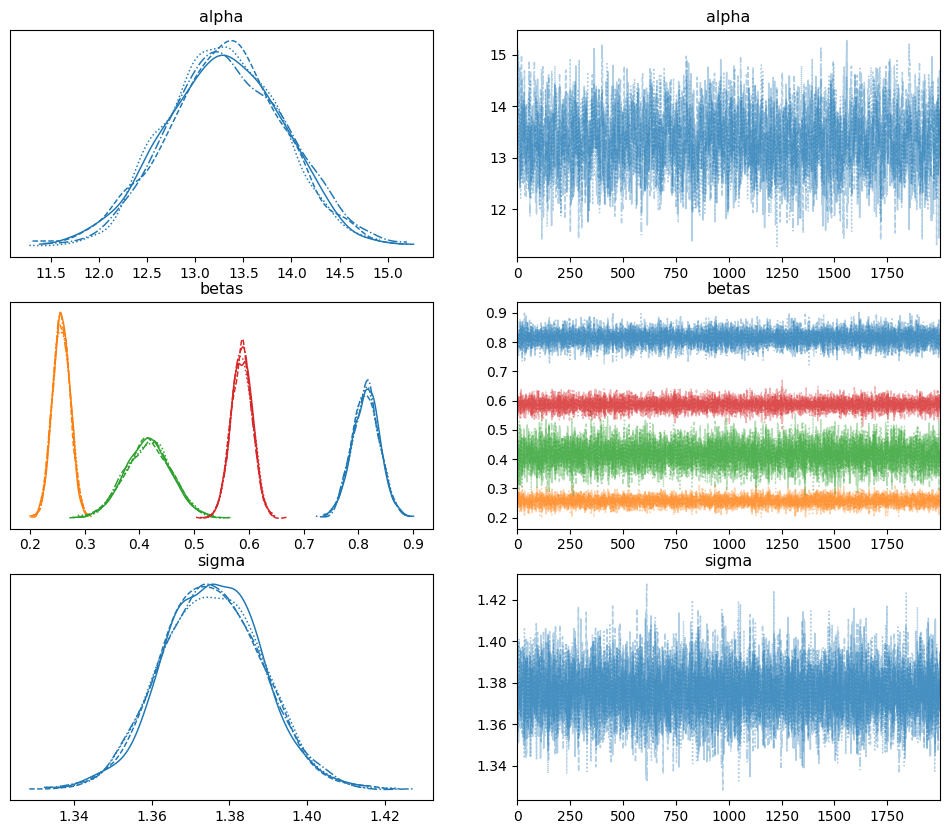

In [59]:
# Adjust layout for better readability
figsize = (12, 10)  # Larger figure size
font_size = 8  # Smaller font size

# Create trace plots
with hierarchical_model:
    az.plot_trace(trace, var_names=["alpha", "betas", "sigma"], figsize=figsize)

# Improve readability
plt.xticks(font_size=8)
plt.yticks(font_size=8)
plt.tight_layout()  # Improve spacing
plt.show()
